Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    #DAF
    #raise Exception(
      #'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    print('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Failed to verify ./notMNIST_small.tar.gz. Can you get to it with a browser?


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders


train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
# PROBLEM 1

def display_images(mypath, num_images):
    for folder in mypath:
        onlyfiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
        print (folder, ":")
        for i in range(num_images):
            print ("-->",onlyfiles[i])
            display(Image(filename=onlyfiles[i]))
    return None

print ("Images from Train DataSet:")
display_images(train_folders, 2)
print ("\nImages from Test DataSet:")
display_images(test_folders, 2)

Images from Train DataSet:
./notMNIST_large/A :
--> ./notMNIST_large/A/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/A/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/B :
--> ./notMNIST_large/B/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/B/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/C :
--> ./notMNIST_large/C/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/C/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/D :
--> ./notMNIST_large/D/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/D/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/E :
--> ./notMNIST_large/E/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/E/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/F :
--> ./notMNIST_large/F/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/F/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/G :
--> ./notMNIST_large/G/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/G/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/H :
--> ./notMNIST_large/H/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/H/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/I :
--> ./notMNIST_large/I/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/I/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png


./notMNIST_large/J :
--> ./notMNIST_large/J/TW9yZ2FuQmlnLUV4dHJhYm9sZC5vdGY=.png


--> ./notMNIST_large/J/VEZGb3JldmVyLUxpZ2h0Lm90Zg==.png



Images from Test DataSet:
./notMNIST_small/A :
--> ./notMNIST_small/A/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/A/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/B :
--> ./notMNIST_small/B/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/B/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/C :
--> ./notMNIST_small/C/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/C/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/D :
--> ./notMNIST_small/D/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/D/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/E :
--> ./notMNIST_small/E/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/E/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/F :
--> ./notMNIST_small/F/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/F/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/G :
--> ./notMNIST_small/G/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/G/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/H :
--> ./notMNIST_small/H/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/H/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/I :
--> ./notMNIST_small/I/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/I/RmF1eENSQS1JdGFsaWMub3Rm.png


./notMNIST_small/J :
--> ./notMNIST_small/J/QW1lcmljYW5hLUJvbGQub3Rm.png


--> ./notMNIST_small/J/RmF1eENSQS1JdGFsaWMub3Rm.png


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

Images from NDArray Train DataSet:
./notMNIST_large/A.pickle


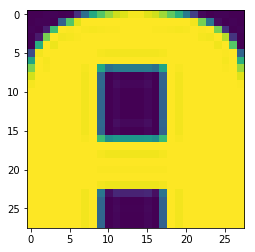

(28, 28)
./notMNIST_large/B.pickle


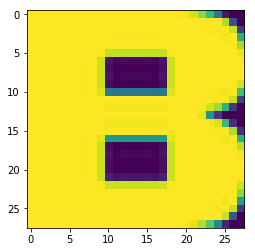

(28, 28)
./notMNIST_large/C.pickle


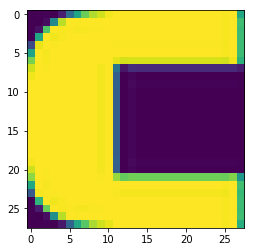

(28, 28)
./notMNIST_large/D.pickle


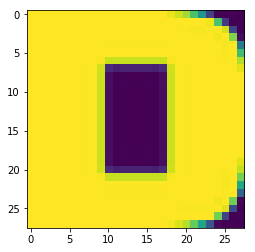

(28, 28)
./notMNIST_large/E.pickle


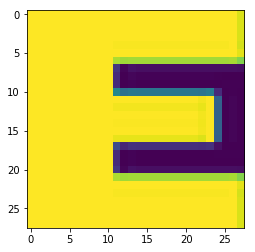

(28, 28)
./notMNIST_large/F.pickle


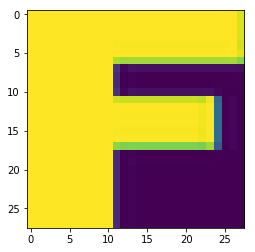

(28, 28)
./notMNIST_large/G.pickle


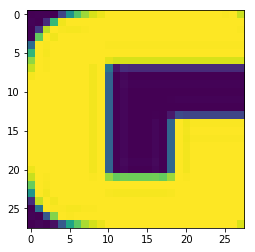

(28, 28)
./notMNIST_large/H.pickle


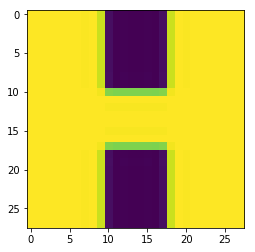

(28, 28)
./notMNIST_large/I.pickle


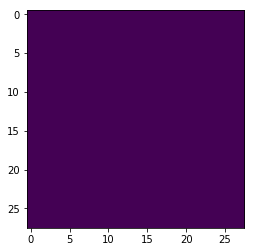

(28, 28)
./notMNIST_large/J.pickle


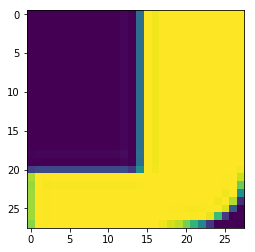

(28, 28)

Images from NDArray Test DataSet:
./notMNIST_small/A.pickle


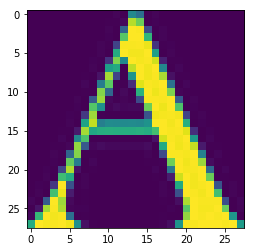

(28, 28)
./notMNIST_small/B.pickle


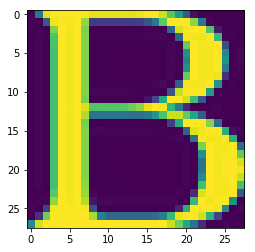

(28, 28)
./notMNIST_small/C.pickle


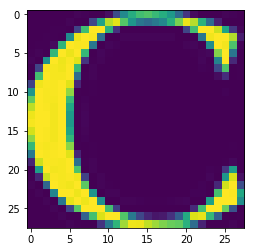

(28, 28)
./notMNIST_small/D.pickle


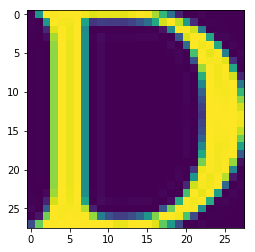

(28, 28)
./notMNIST_small/E.pickle


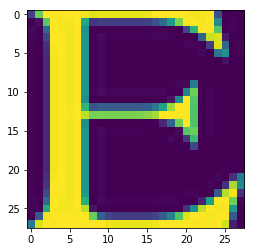

(28, 28)
./notMNIST_small/F.pickle


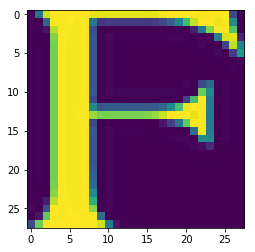

(28, 28)
./notMNIST_small/G.pickle


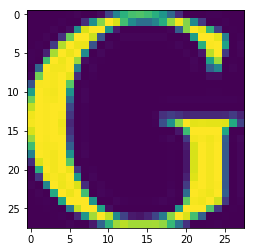

(28, 28)
./notMNIST_small/H.pickle


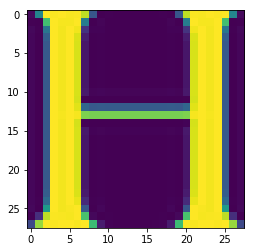

(28, 28)
./notMNIST_small/I.pickle


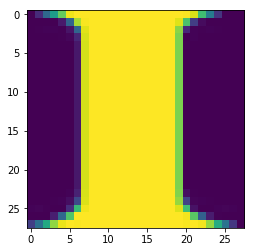

(28, 28)
./notMNIST_small/J.pickle


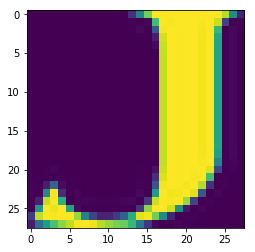

(28, 28)


In [6]:
def display_images_from_pickle_files(pickle_files, num_images):
    for f in pickle_files:
        print(f)
        dataset = np.load(f, mmap_mode='r')
        for i in range(num_images):
            image_data = dataset[i, :, :]
            plt.imshow(image_data)
            plt.show()
            print(image_data.shape)
    return None

print ("Images from NDArray Train DataSet:")
display_images_from_pickle_files(train_datasets, 1)
print ("\nImages from NDArray Test DataSet:")
display_images_from_pickle_files(test_datasets, 1)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

Class Balance from Train DataSet:
Class A: N=52909 Mean=-0.12825 Sd=0.44312
Class B: N=52911 Mean=-0.00756304 Sd=0.454492
Class C: N=52912 Mean=-0.142258 Sd=0.439806
Class D: N=52911 Mean=-0.0573678 Sd=0.455648
Class E: N=52912 Mean=-0.069899 Sd=0.452942
Class F: N=52912 Mean=-0.125583 Sd=0.447089
Class G: N=52912 Mean=-0.0945817 Sd=0.44624
Class H: N=52912 Mean=-0.0685222 Sd=0.454232
Class I: N=52912 Mean=0.0307862 Sd=0.468898
Class J: N=52911 Mean=-0.153358 Sd=0.443656


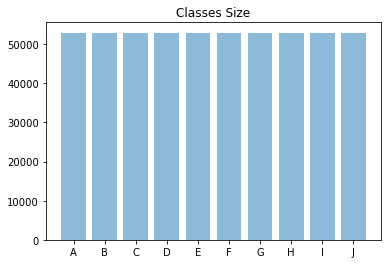

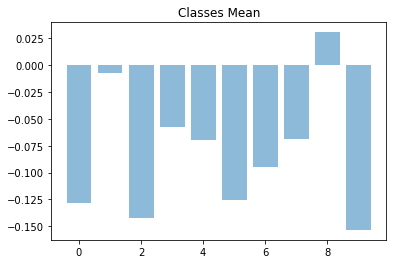

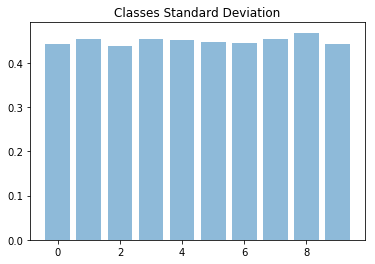


Class Balance from Test DataSet:
Class A: N=1872 Mean=-0.132626 Sd=0.445128
Class B: N=1873 Mean=0.00535608 Sd=0.457115
Class C: N=1873 Mean=-0.141521 Sd=0.44269
Class D: N=1873 Mean=-0.0492167 Sd=0.459759
Class E: N=1873 Mean=-0.0599148 Sd=0.45735
Class F: N=1872 Mean=-0.118185 Sd=0.452279
Class G: N=1872 Mean=-0.0925503 Sd=0.449006
Class H: N=1872 Mean=-0.0586892 Sd=0.458759
Class I: N=1872 Mean=0.0526451 Sd=0.471893
Class J: N=1872 Mean=-0.151689 Sd=0.448014


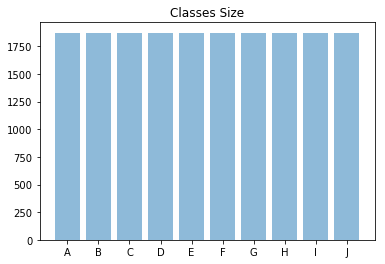

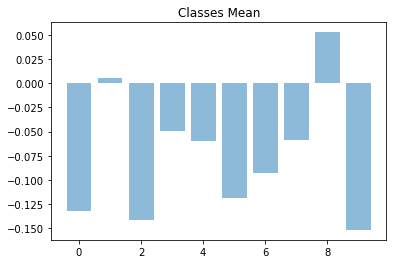

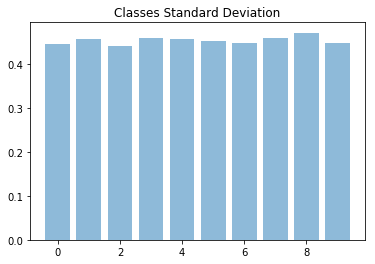

In [7]:
def show_class_balance(pickle_files):

    datasets_labels = []
    
    datasets_size = np.empty(len(pickle_files),)
    datasets_mean = np.empty(len(pickle_files))
    datasets_sd = np.empty(len(pickle_files)) 
    
    i=0
    for f in pickle_files:
        dataset = np.load(f, mmap_mode='r')
        datasets_labels.append(os.path.splitext(os.path.basename(f))[0])
        datasets_size[i] = dataset.shape[0]
        datasets_mean[i] = np.mean(dataset)
        datasets_sd[i] = np.std(dataset)
                
        print("Class %s: N=%s Mean=%s Sd=%s" % (os.path.splitext(os.path.basename(f))[0], dataset.shape[0], np.mean(dataset), np.std(dataset)))        
        i += 1
    
    y_pos = np.arange(len(datasets_labels))
    plt.xticks(y_pos, datasets_labels)

    plt.title('Classes Size')    
    plt.bar(y_pos, datasets_size, align='center', alpha=0.5)
    plt.show()

    plt.title('Classes Mean')
    plt.bar(y_pos, datasets_mean, align='center', alpha=0.5)
    plt.show()

    plt.title('Classes Standard Deviation')
    plt.bar(y_pos, datasets_sd, align='center', alpha=0.5)
    plt.show()
    
    return None



print ("Class Balance from Train DataSet:")
show_class_balance(train_datasets)
print ("\nClass Balance from Test DataSet:")
show_class_balance(test_datasets)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)

_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Images from Train DataSet:
From Class 6:


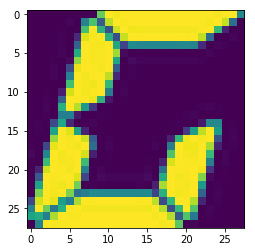

From Class 1:


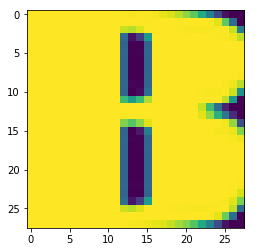

From Class 9:


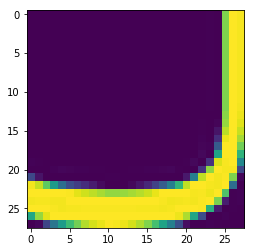

Images from Validation DataSet:
From Class 7:


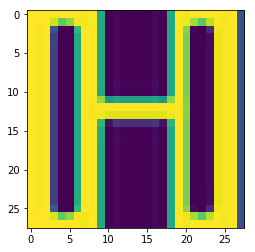

From Class 6:


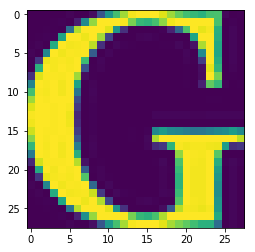

From Class 1:


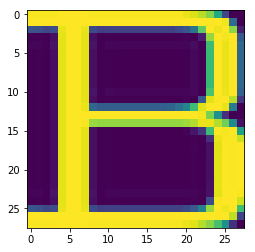


Images from Test DataSet:
From Class 7:


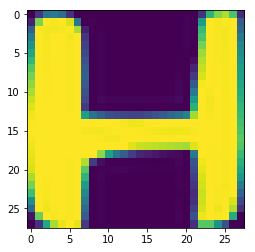

From Class 2:


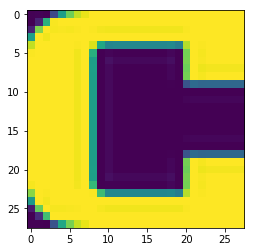

From Class 6:


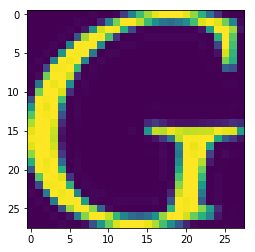

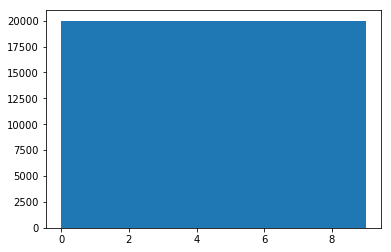

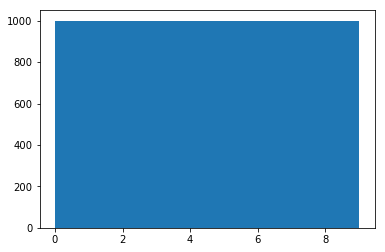

<function matplotlib.pyplot.show>

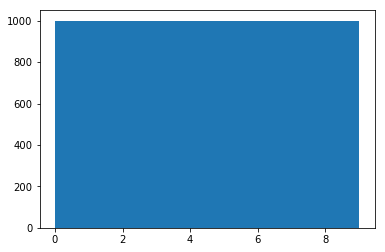

In [10]:
#
from collections import Counter
Counter(train_labels), Counter(test_labels)
#np.bincount(test_labels)

# For 4 I also displayed some images and their labels to make sure they still correspond
def display_random_images_from_dataset(dataset, labels, num_images):

    r = np.random.choice(labels.shape[0], num_images)
    
    for i in range(num_images):
        
        idx = r[i]
        image_class = labels[idx]
        image_data = dataset[idx, :, :]
        print("From Class %s:" % image_class)
        plt.imshow(image_data)
        plt.show()            

    return None

print ("Images from Train DataSet:")
display_random_images_from_dataset(train_dataset, train_labels, 3)

print ("Images from Validation DataSet:")
display_random_images_from_dataset(valid_dataset, valid_labels, 3)

print ("\nImages from Test DataSet:")
display_random_images_from_dataset(test_dataset, test_labels, 3)

# PROBLEM 3, having labels generated
plt.hist(train_labels, 10)
plt.show()
plt.hist(valid_labels, 10)
plt.show()
plt.hist(test_labels, 10)
plt.show

Finally, let's save the data for later reuse:

In [11]:
print (train_dataset.shape)
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

(200000, 28, 28)


In [12]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [13]:
data_root = '.'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
with open(pickle_file, 'rb') as handle:
    data = pickle.load(handle)

train_dataset = data['train_dataset']
train_labels = data.get('train_labels')
valid_dataset = data.get('valid_dataset')
valid_labels = data.get('valid_labels')
test_dataset = data.get('test_dataset')
test_labels = data.get('test_labels')

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [14]:
#I agree the merge_datasets func cannot produce repeated images
#, but I think there are repeated images in the original samples.
#So some fonts are duplicate and all some fonts may have at least nearly duplicates.

# After reading all the thread about this, I select the following solution. Because of its code quality, 
# understanding and performance: It solves 1.5.1 (measure overlap of identical duplicates) 
# and the optional questions 1.5.2 (measure overlap of closer duplicates) and 1.5.2 (create sanitized datasets)
# The point of it is: The approximation happens in the hashing function dhash. 
# While np.in1d() will only give exact hash matches, 
# the dhash function has assigned similar images with identical hash values.


# import the necessary packages
from PIL import Image
import hashlib
import imagehash

def print_overlap_num(valid_in_train, test_in_train, test_in_valid):
    print("valid -> train overlap: %d samples" % valid_in_train.sum())
    print("test  -> train overlap: %d samples" % test_in_train.sum())
    print("test  -> valid overlap: %d samples\n" % test_in_valid.sum())


def create_sanitized_datasets(hfun):

    train_hash = [hfun(x) for x in train_dataset]
    valid_hash = [hfun(x) for x in valid_dataset]
    test_hash = [hfun(x) for x in test_dataset]

    valid_in_train = np.in1d(valid_hash, train_hash)
    test_in_train  = np.in1d(test_hash,  train_hash)
    test_in_valid  = np.in1d(test_hash,  valid_hash)

    valid_keep = ~valid_in_train
    test_keep  = ~(test_in_train | test_in_valid)

    valid_dataset_clean = valid_dataset[valid_keep]
    valid_labels_clean  = valid_labels [valid_keep]

    test_dataset_clean = test_dataset[test_keep]
    test_labels_clean  = test_labels [test_keep]
        
    print_overlap_num(valid_in_train, test_in_train, test_in_valid)
    
    return train_dataset, train_labels, valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean  


    
#1.5.1
create_sanitized_datasets(lambda x: hashlib.sha1(x).digest())

#1.5.2 & 1.5.3 (choose the worst case: the sanitized datasets must not contain near duplicated images)
train_dataset_clean, train_labels_clean, valid_dataset_clean, valid_labels_clean, test_dataset_clean, test_labels_clean = create_sanitized_datasets(
    lambda x: str(imagehash.dhash(Image.fromarray(np.uint8(x*255)))) )

valid -> train overlap: 1044 samples
test  -> train overlap: 1316 samples
test  -> valid overlap: 198 samples

valid -> train overlap: 1249 samples
test  -> train overlap: 1577 samples
test  -> valid overlap: 292 samples



---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [15]:
#Reshape for LogisticRegression

(samples, width, height) = train_dataset_clean.shape
train_X = np.reshape(train_dataset_clean,(samples,width*height))
train_y = train_labels_clean

(samples, width, height) = valid_dataset_clean.shape
valid_X = np.reshape(valid_dataset_clean,(samples,width*height))
valid_y = valid_labels_clean

(samples, width, height) = test_dataset_clean.shape
test_X = np.reshape(test_dataset_clean,(samples,width*height))
test_y = test_labels_clean

print(train_X.shape)
print(train_y.shape)

(200000, 784)
(200000,)


N=5000, l2_penalty_coefficient=200.0000, C=0.0050
Score with L2 penalty: 0.8396
Validation Accuracy Rate: 0.8010 AND Validation Error Rate: 0.1990

N=5000, l2_penalty_coefficient=100.0000, C=0.0100
Score with L2 penalty: 0.8516
Validation Accuracy Rate: 0.8026 AND Validation Error Rate: 0.1974

N=5000, l2_penalty_coefficient=50.0000, C=0.0200
Score with L2 penalty: 0.8648
Validation Accuracy Rate: 0.7968 AND Validation Error Rate: 0.2032

N=5000, l2_penalty_coefficient=33.3333, C=0.0300
Score with L2 penalty: 0.8726
Validation Accuracy Rate: 0.7952 AND Validation Error Rate: 0.2048

N=5000, l2_penalty_coefficient=20.0000, C=0.0500
Score with L2 penalty: 0.8858
Validation Accuracy Rate: 0.7930 AND Validation Error Rate: 0.2070

N=5000, l2_penalty_coefficient=16.6667, C=0.0600
Score with L2 penalty: 0.8888
Validation Accuracy Rate: 0.7924 AND Validation Error Rate: 0.2076



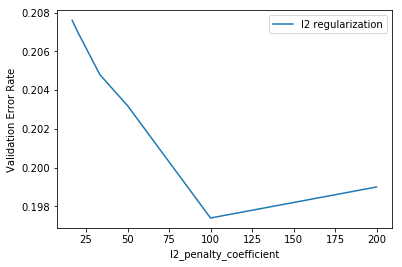

In [16]:
#Choosing the best C: It resulted to be C=0.0100 for N=1000 & N=5000

#inverse_reg_strengths = [100.0 , 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]
inverse_reg_strengths = [0.005, 0.01, 0.02, 0.03, 0.05, 0.06]

N = 5000
yy_ = []
xx_ = []

for i, C in enumerate(inverse_reg_strengths):
    
    # turn down tolerance for short training time
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=C, penalty='l2', tol=0.01)
    model.fit(train_X[0:N], train_y[0:N])
    model_coeff = model.coef_.ravel()

    y_hat = model.predict(valid_X[0:N])
    error = (1 - np.mean(y_hat == valid_y[0:N]))
    accuracy = sum(y_hat == valid_y[0:N]) / float(len(valid_y[0:N]))

    yy_.append(error)
    xx_.append(1/C)
    
    print("N=%s, l2_penalty_coefficient=%.4f, C=%.4f" % (N,1.0/C, C))
    print("Score with L2 penalty: %.4f" % model.score(train_X[0:N], train_y[0:N]))
    print("Validation Accuracy Rate: %.4f AND Validation Error Rate: %.4f\n" % (accuracy, error))

plt.plot(xx_, yy_, label="l2 regularization")
plt.legend(loc="upper right")
plt.xlabel("l2_penalty_coefficient")
plt.ylabel("Validation Error Rate")
plt.show()

In [17]:
print(model.coef_.shape)

(10, 784)


N=50, l2_penalty_coeff=100.00, C=0.0100
Score with L2 penalty: 0.9400
Test Accuracy Rate: 0.3400 AND Test Error Rate: 0.6600

N=100, l2_penalty_coeff=100.00, C=0.0100
Score with L2 penalty: 0.9000
Test Accuracy Rate: 0.6200 AND Test Error Rate: 0.3800

N=1000, l2_penalty_coeff=100.00, C=0.0100
Score with L2 penalty: 0.8550
Test Accuracy Rate: 0.8410 AND Test Error Rate: 0.1590

N=5000, l2_penalty_coeff=100.00, C=0.0100
Score with L2 penalty: 0.8516
Test Accuracy Rate: 0.8646 AND Test Error Rate: 0.1354



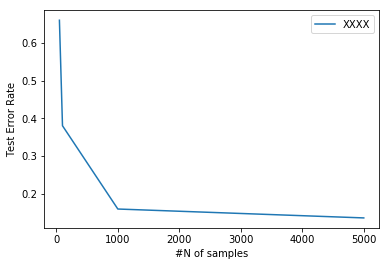

In [18]:
C=0.0100 #the best
yy_ = []
xx_ = []
for N in [50, 100, 1000, 5000]:
    
    # turn down tolerance for short training time
    model_l2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.0100, penalty='l2', tol=0.01)
    model_l2.fit(train_X[0:N], train_y[0:N])
    model_l2_coef = model_l2.coef_.ravel()

    y_hat = model_l2.predict(test_X[0:N])
    error = (1 - np.mean(y_hat == test_y[0:N]))
    accuracy = sum(y_hat == test_y[0:N]) / float(len(test_y[0:N]))

    yy_.append(error)
    xx_.append(N)

    
    print("N=%s, l2_penalty_coeff=%.2f, C=%.4f" % (N,1.0/C,C))
    print("Score with L2 penalty: %.4f" % model_l2.score(train_X[0:N], train_y[0:N]))
    print("Test Accuracy Rate: %.4f AND Test Error Rate: %.4f\n" % (accuracy, error))

plt.plot(xx_, yy_, label="XXXX")
plt.legend(loc="upper right")
plt.xlabel("#N of samples")
plt.ylabel("Test Error Rate")
plt.show()

In [19]:
#Optional question: train an off-the-shelf model on all the data!

N = train_X.shape[0]
N_test = test_X.shape[0]
C=0.0100

model_l2_all = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=0.0100, penalty='l2', tol=0.01)
model_l2_all.fit(train_X[0:N], train_y[0:N])
model_l2_all_coef = model_l2_all.coef_.ravel()

y_hat = model_l2_all.predict(test_X[0:N_test])
error = (1 - np.mean(y_hat == test_y[0:N_test]))
accuracy = sum(y_hat == test_y[0:N_test]) / float(N_test)

print("N=%s, l2_penalty_coeff=%.2f, C=%.4f" % (N,1.0/C,C))
print("Score with L2 penalty: %.4f" % model_l2_all.score(train_X[0:N], train_y[0:N]))
print("Test Accuracy Rate: %.4f AND Test Error Rate: %.4f\n" % (accuracy, error))

MemoryError: 

In [20]:
(samples, width, height) = test_dataset.shape
valid_X = np.reshape(valid_dataset,(samples,width*height))
valid_y = valid_labels

(samples, width, height) = test_dataset.shape
test_X = np.reshape(test_dataset,(samples,width*height))
test_y = test_labels

(samples, width, height) = test_dataset_clean.shape
test_X_clean = np.reshape(test_dataset_clean,(samples,width*height))
test_y_clean = test_labels_clean

In [21]:
clean_pickle_file = os.path.join(data_root, 'clean_notMNIST.pickle')
try:
  f = open(clean_pickle_file, 'wb')
  save = {
    'train_dataset_clean': train_dataset_clean,
    'train_labels_clean': train_labels_clean,
    'valid_dataset_clean': valid_dataset_clean,
    'valid_labels_clean': valid_labels_clean,
    'test_dataset_clean': test_dataset_clean,
    'test_labels_clean': test_labels_clean,
    'model_l2_all': model_l2_all,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', clean_pickle_file, ':', e)
  raise

N=50, l2_penalty_coeff=1000.00, C=0.0010
score for test dataset: 0.2200
score for test dataset cleaned: 0.1600

N=100, l2_penalty_coeff=1000.00, C=0.0010
score for test dataset: 0.3600
score for test dataset cleaned: 0.3600

N=1000, l2_penalty_coeff=1000.00, C=0.0010
score for test dataset: 0.8310
score for test dataset cleaned: 0.8120

N=5000, l2_penalty_coeff=1000.00, C=0.0010
score for test dataset: 0.8608
score for test dataset cleaned: 0.8468

N=10000, l2_penalty_coeff=1000.00, C=0.0010
score for test dataset: 0.8732
score for test dataset cleaned: 0.8590



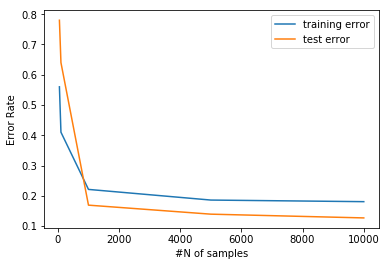

In [22]:
#Student Check (All dataset are uncleared)

C=0.001 #the choosen by the students. The problem is not to fix a seed
NSamples = [50, 100, 1000, 5000, 10000]
error_train_l, error_test_l = [], []

for N in NSamples:
    
    # turn down tolerance for short training time
    model_l2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=C, penalty='l2', tol=0.01)
    model_l2.fit(train_X[0:N], train_y[0:N])
    model_l2_coef = model_l2.coef_.ravel()

    y_hat_train = model_l2.predict(train_X[0:N])
    error_train = (1 - np.mean(y_hat_train == train_y[0:N]))
    accuracy_train = sum(y_hat_train == train_y[0:N]) / float(len(train_y[0:N]))

    y_hat_test = model_l2.predict(test_X[0:N])
    error_test = (1 - np.mean(y_hat_test == test_y[0:N]))
    accuracy_test = sum(y_hat_test == test_y[0:N]) / float(len(test_y[0:N]))

    y_hat_test_clean = model_l2.predict(test_X_clean[0:N])
    error_test_clean = (1 - np.mean(y_hat_test_clean == test_y_clean[0:N]))
    accuracy_test_clean = sum(y_hat_test_clean == test_y_clean[0:N]) / float(len(test_y_clean[0:N]))
    
    error_train_l.append(error_train)
    error_test_l.append(error_test)
        
    print("N=%s, l2_penalty_coeff=%.2f, C=%.4f" % (N,1.0/C,C))
    #print("score for train dataset: %.4f" %model_l2.score(train_X[0:N], train_y[0:N]))
    print("score for test dataset: %.4f" % model_l2.score(test_X[0:N], test_y[0:N]))
    print("score for test dataset cleaned: %.4f\n" % model_l2.score(test_X_clean[0:N], test_y_clean[0:N]))
    
###
plt.plot(NSamples, error_train_l, label="training error")
plt.plot(NSamples, error_test_l, label="test error")
plt.legend(loc="upper right")
plt.xlabel("#N of samples")
plt.ylabel("Error Rate")
plt.show()

[0.44, 0.58999999999999997, 0.69599999999999995, 0.75800000000000001, 0.77900000000000003, 0.81359999999999999, 0.81420000000000003, 0.81950000000000001]
[0.22, 0.40999999999999998, 0.58399999999999996, 0.76800000000000002, 0.78700000000000003, 0.80000000000000004, 0.80400000000000005, 0.81440000000000001]
[0.22, 0.35999999999999999, 0.64000000000000001, 0.76800000000000002, 0.83099999999999996, 0.85040000000000004, 0.86080000000000001, 0.87319999999999998]


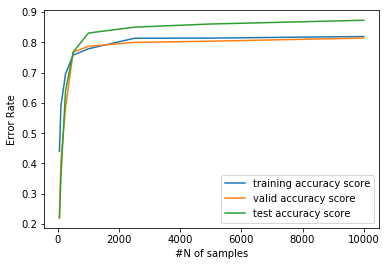

In [23]:
#Student Check II (All dataset are uncleared)

from sklearn.metrics import accuracy_score

C=0.001 #the choosen by the students. The problem is not to fix a seed
NSamples = [50, 100, 250, 500, 1000, 2500, 5000, 10000]
score_train, score_test, score_valid = [], [], []

for N in NSamples:
    
    # turn down tolerance for short training time
    model_l2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=C, penalty='l2', tol=0.01)
    model_l2.fit(train_X[0:N], train_y[0:N])
    model_l2_coef = model_l2.coef_.ravel()

    y_hat_train = model_l2.predict(train_X[0:N])
    y_hat_valid = model_l2.predict(valid_X[0:N])
    y_hat_test = model_l2.predict(test_X[0:N])
    
    score_train.append(accuracy_score(train_y[0:N], y_hat_train) )
    score_valid.append(accuracy_score(valid_y[0:N], y_hat_valid) )
    score_test.append(accuracy_score(test_y[0:N], y_hat_test) )
    
###
print(score_train)
print(score_valid)
print(score_test)

plt.plot(NSamples, score_train, label="training accuracy score")
plt.plot(NSamples, score_valid, label="valid accuracy score")
plt.plot(NSamples, score_test, label="test accuracy score")
plt.legend(loc="lower right")
plt.xlabel("#N of samples")
plt.ylabel("Error Rate")
plt.show()

# Samples:5000, Penalty:1, Accuracy:82.016967%
(200000, 28, 28)
(200000,)
(5000, 784)
(784,)
(5000,)
()
(10, 784)
(784,)
(10,)
0.53446740534


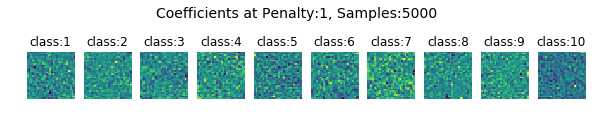

# Samples:5000, Penalty:0.1, Accuracy:85.553830%
(200000, 28, 28)
(200000,)
(5000, 784)
(784,)
(5000,)
()
(10, 784)
(784,)
(10,)
0.532774880138


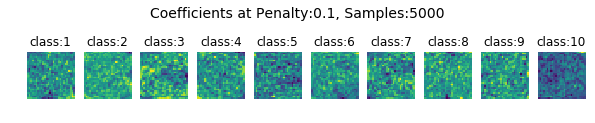

# Samples:5000, Penalty:0.01, Accuracy:86.916000%
(200000, 28, 28)
(200000,)
(5000, 784)
(784,)
(5000,)
()
(10, 784)
(784,)
(10,)
0.422060061168


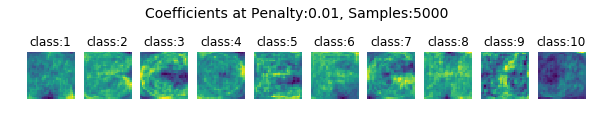

# Samples:5000, Penalty:0.001, Accuracy:85.063926%
(200000, 28, 28)
(200000,)
(5000, 784)
(784,)
(5000,)
()
(10, 784)
(784,)
(10,)
0.297105395501


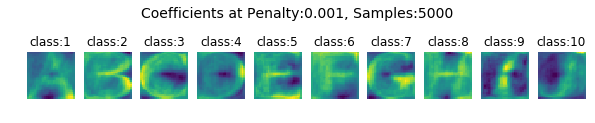

# Samples:5000, Penalty:0.0001, Accuracy:80.595053%
(200000, 28, 28)
(200000,)
(5000, 784)
(784,)
(5000,)
()
(10, 784)
(784,)
(10,)
0.070312826606


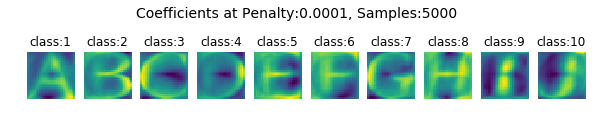

In [24]:
#The meaning of the Logistic Regression Coefficients and the influence of C (l2_penalty)

num_classes = 10
training_samples = 5000
for penalty in [1, 0.1, 0.01, 0.001, 0.0001]:
    (samples, width, height) = train_dataset.shape
    X_tr = train_dataset.reshape(samples, width * height)[0:training_samples]
    y_tr = train_labels[0:training_samples]
    clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                             random_state=42, verbose=0, max_iter=1000, 
                             penalty='l2', C=penalty)
    clf.fit(X_tr, y_tr)
    (samples, width, height) = test_dataset_clean.shape
    X_tst = test_dataset_clean.reshape(samples, width * height)
    y_tst = test_labels_clean
    # h_tst = clf.predict(X_tst)
    print('# Samples:%s, Penalty:%s, Accuracy:%f%%' % 
          (training_samples, penalty, clf.score(X_tst, y_tst)*100))
    
    #DAF understanding: shapes
    print(train_dataset.shape)
    print(train_labels.shape)
    print(X_tr.shape)
    print(X_tr[0].shape)
    print(y_tr.shape)
    print(y_tr[0].shape)
    print(clf.coef_.shape)
    print(clf.coef_[0].shape)
    print(clf.intercept_.shape)
    print(clf.intercept_[0])
    
    
    fig = plt.figure()
    fig.set_size_inches(10, 2)
    fig.suptitle('Coefficients at Penalty:%s, Samples:%s' %
                 (penalty, training_samples), fontsize=14)
    filters = np.ndarray(shape=(num_classes, width, height), dtype=np.float32)
    for class_i in range(0,(num_classes)):
        filters[class_i, :, :] = clf.coef_.reshape(num_classes, width, height)[class_i]
        a = fig.add_subplot(1, 10, (class_i+1))
        a.set_title('class:%s' % (class_i+1))
        plt.imshow(filters[class_i])
        plt.axis('off')
    plt.show()

In [25]:
# Regularization parameter values to be used
lambda_values = np.array([0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 1.0])

# Error array (1 - accuracy) with index correspond to each regularization parameter value
train_error_values = np.array([0.0]*len(lambda_values))
valid_error_values = np.array([0.0]*len(lambda_values))

# Set training, validation and test set sizes (60-20-20 split of dataset)
train_size = 6000
valid_size = train_size / 3

# Replace original dataset by sanitized dataset
train_dataset_ = train_dataset_clean[0:train_size, :, :]
valid_dataset_ = valid_dataset_clean[0:valid_size, :, :]
train_labels_ = train_labels_clean[0:train_size]
valid_labels_ = valid_labels_clean[0:valid_size]

# Flatten dataset for training the model
flatten_train_dataset = train_dataset_.reshape((train_size, image_size*image_size))
flatten_valid_dataset = valid_dataset_.reshape((valid_size, image_size*image_size))

for i, L in enumerate(lambda_values):
    # Create and train model
    model_l2 = LogisticRegression(C=L, multi_class='multinomial', solver='lbfgs', random_state=42, verbose=0, max_iter=1000)
    model_l2.fit(flatten_train_dataset, train_labels_)
    # Predict
    train_yhat = model_l2.predict(flatten_train_dataset)
    valid_yhat = model_l2.predict(flatten_valid_dataset)
    # Calculate error
    accuracy_train = accuracy_score(train_labels_, train_yhat)
    accuracy_valid = accuracy_score(valid_labels_, valid_yhat)
    train_error_values[i] = 1 - accuracy_train
    valid_error_values[i] = 1 - accuracy_valid

[ 0.23433333  0.20633333  0.186       0.16883333  0.15083333  0.13016667
  0.038     ]
[ 0.251   0.217   0.2025  0.194   0.19    0.1945  0.2465]


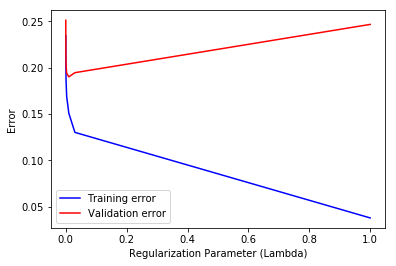

Minimum cost is 0.19 with corresponding regularization parameter (lambda) value as 0.01


In [26]:
print(train_error_values)
print(valid_error_values)
# Plot curves 
plt.plot(lambda_values, train_error_values, 'b', label='Training error')
plt.plot(lambda_values, valid_error_values, 'r', label='Validation error')
plt.xlabel('Regularization Parameter (Lambda)')
plt.ylabel('Error')
plt.legend()
plt.show()

# Set regularization_parameter value
reg_param = lambda_values[valid_error_values.argmin()]

print('Minimum cost is {} with corresponding regularization parameter (lambda) value as {}'.format(
                                                                                    min(valid_error_values),
                                                                                    reg_param))